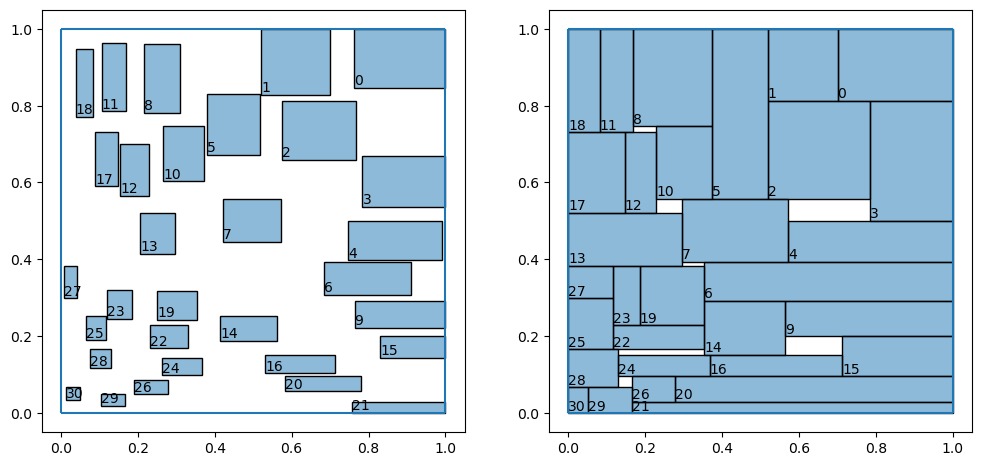

In [19]:
from SquareDivision.src.rectangle_class import Rectangulation

rects = Rectangulation()#config={'seed' : 180000007})
rects.execute(num=10)
rects.draw()

In [17]:
rects.prepare_constraints()
rects.holes_idxs

[[[7, 1], [4, 3]],
 [[11, 5], [10, 4]],
 [[17, 10], [12, 11]],
 [[20, 16], [18, 14]],
 [[23, 14], [20, 13]],
 [[26, 13], [23, 27]],
 [[25, 12], [24, 17]],
 [[35, 24], [28, 25]],
 [[29, 22], [32, 18]],
 [[34, 20], [30, 23]],
 [[36, 29], [32, 30]],
 [[39, 35], [41, 32]],
 [[38, 37], [40, 34]]]

#### nonlinear by name `x * y == 0` conditions for closing holes

In [4]:
holes

[[2, 3, 4, 7],
 [7, 6, 19, 13],
 [7, 10, 12, 13],
 [8, 10, 12, 11],
 [9, 14, 16, 15],
 [14, 22, 28, 24],
 [24, 26, 29, 28]]

In [5]:
from scipy.optimize import NonlinearConstraint
from SquareDivision.holes.detect import hole_closing_idxs
from SquareDivision.optimization.constraints import contacts_after_hole_closing, hole_closing_jac
import copy
clinched_rectangles:np.ndarray

holes_constraints = []
for hole in holes:
    idxs_to_close = hole_closing_idxs(hole, clinched_rectangles)
    holes_constraints.append(
        NonlinearConstraint(
            fun=lambda x, hole_closing_idxs=idxs_to_close : contacts_after_hole_closing(x, hole_closing_idxs),
            jac=lambda x, hole_closing_idxs=idxs_to_close : hole_closing_jac(x, hole_closing_idxs),
            lb=0, ub=0)
    )

In [6]:
for constraint in holes_constraints:
    constraint:NonlinearConstraint
    print(constraint.fun(clinched_rectangles.flatten()))
# FIX to nie moze byc to samo, dla róznych diur ma byc inaczej 

0.012165843846628197
0.0006083261498763344
0.0024510725831778817
0.001004279134926422
0.007253147506859762
0.0033444809503871283
0.0010212271295869893


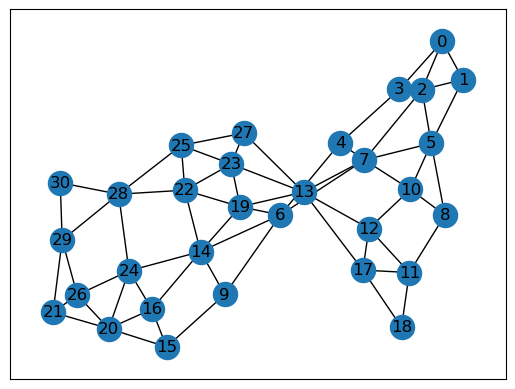

In [ ]:
import networkx as nx
from SquareDivision.holes.detect import graph_from_neighbours_arrays
north_graph = graph_from_neighbours_arrays(north_neighbours, 0)
all_graph = graph_from_neighbours_arrays(north_neighbours, east_neighbours)
# nx.draw_networkx(north_graph,pos=nx.spring_layout(north_graph))
nx.draw_networkx(all_graph)#|, pos=nx.spring_layout(all_graph))

## Projection onto retrangulation without holes

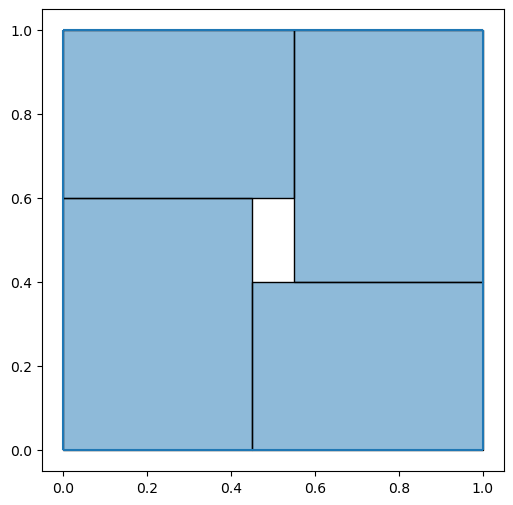

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles


width, height = np.array([0.1, 0.2]) / 2
rect_area = (0.5 - width)*(0.5 + height)
arr_with_hole = np.array([
    [          0,            0, 0.5 - width, 0.5 + height, (0.5 - width) * (0.5 + height)],
    [          0, 0.5 + height, 0.5 + width, 0.5 - height, (0.5 + width) * (0.5 - height)],
    [0.5 + width, 0.5 - height, 0.5 - width, 0.5 + height, (0.5 - width) * (0.5 + height)],
    [0.5 - width,            0, 0.5 + width, 0.5 - height, (0.5 + width) * (0.5 - height)],
])
#additional name for future
clinched_rectangles = arr_with_hole
fig, ax = plt.subplots(figsize=(6, 6))
ax = draw_rectangles(ax, arr_with_hole)
plt.show()

east_neighbours = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0]
])
north_neighbours = np.array([
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,1,0]
])

In [ ]:
arr_with_hole

array([[0.  , 0.  , 0.4 , 0.55, 0.22],
       [0.  , 0.55, 0.6 , 0.45, 0.27],
       [0.6 , 0.45, 0.4 , 0.55, 0.22],
       [0.4 , 0.  , 0.6 , 0.45, 0.27]])

### condition building on `[x, y, width, height, area]` such that:
sum of areas is 1, apropriate sums of height and width are 1, first build matrix `A`

In [ ]:
east_neighbours = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0]
])
north_neighbours = np.array([
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,1,0]
])


#### bounds

In [ ]:
def bounds_from_clinched(clinched_rectangles:np.ndarray):
    n, m = clinched_rectangles.shape
    lb = np.zeros(shape= n * 5)
    ub = np.ones(shape= n * 5)
    for num, row in enumerate(clinched_rectangles):
        idx = 5 * num
        if np.isclose(row[0], 0) and np.isclose(row[1], 0): 
            lb[idx], ub[idx], lb[idx+1], ub[idx+1] = 0, 0, 0, 0
            continue # keep (0,0) corner
        elif np.isclose(row[0], 0) and (not np.isclose(row[1], 0)):
            lb[idx], ub[idx] = 0, 0 
            continue # keep-left
        elif (not np.isclose(row[0], 0)) and np.isclose(row[1], 0):
            lb[idx+1], ub[idx+1] = 0, 0
            continue # keep-bottom
        else:
            continue
    return lb, ub
        

In [ ]:
from scipy.optimize import Bounds
lb, ub = bounds_from_clinched(clinched_rectangles)
bounds = Bounds(lb=lb, ub=ub, keep_feasible=np.array([True]*20))

#### New functions fo constraints

In [ ]:
from scipy.optimize import LinearConstraint, NonlinearConstraint
from SquareDivision.optimization.constraints import (
    low_boundary_constraint_args,
    high_boundary_constraint_args,
    contact_constraint_args,
    area_constraint_fun,
    area_jac
)
from SquareDivision.optimization.objective_function import (
    dist_fun
)
from SquareDivision.optimization.initial_guess import (
    contact_universal_x0
)

In [ ]:
clinched_rectangles = clinched_rectangles[:,:4]
low__X_A, low__X_rhs = low_boundary_constraint_args(clinched_rectangles, east_neighbours, axis=0)
low__Y_A, low__Y_rhs = low_boundary_constraint_args(clinched_rectangles, north_neighbours, axis=1)
high_X_A, high_X_rhs = high_boundary_constraint_args(clinched_rectangles, east_neighbours, axis=0)
high_Y_A, high_Y_rhs = high_boundary_constraint_args(clinched_rectangles, north_neighbours, axis=1)
low__X_constr = LinearConstraint( A=low__X_A, lb=low__X_rhs, ub=low__X_rhs)
low__Y_constr = LinearConstraint( A=low__Y_A, lb=low__Y_rhs, ub=low__Y_rhs)
high_X_constr = LinearConstraint( A=high_X_A, lb=high_X_rhs, ub=high_X_rhs)
high_Y_constr = LinearConstraint( A=high_Y_A, lb=high_Y_rhs, ub=high_Y_rhs)

cont_X_A, cont_X_rhs = contact_constraint_args(clinched_rectangles, east_neighbours, axis=0)
cont_Y_A, cont_Y_rhs = contact_constraint_args(clinched_rectangles, north_neighbours, axis=1)
horizontal_contacts = LinearConstraint( A=cont_X_A, lb=cont_X_rhs, ub=cont_X_rhs)
vertical___contacts = LinearConstraint( A=cont_Y_A, lb=cont_Y_rhs, ub=cont_Y_rhs)

area_constr = NonlinearConstraint(fun=area_constraint_fun, jac=area_jac, lb=0, ub=0)
constraints = [
    low__X_constr, low__Y_constr,
    high_X_constr, high_Y_constr,
    horizontal_contacts,
    vertical___contacts,
    area_constr].extend(holes_constraints)

x0 = contact_universal_x0(clinched_rectangles=clinched_rectangles).flatten()

In [ ]:
from scipy.optimize import minimize
# x0 = build_x0(arr_with_hole)
# x0 = x0_cross_ab(0.2,0.3)
# x0 = contact_universal_x0(clinched_rectangles).flatten()
sol = minimize(dist_fun, x0=x0, args=(clinched_rectangles), jac=True, method='trust-constr', constraints=constraints)#, bounds=bounds)

In [ ]:
sol#.x.reshape(-1,4)

          message: `gtol` termination condition is satisfied.
          success: True
           status: 1
              fun: 6.722458470883647e-31
                x: [ 7.005e-01  8.128e-01 ...  5.020e-02  6.705e-02]
              nit: 3
             nfev: 3
             njev: 3
             nhev: 0
         cg_niter: 2
     cg_stop_cond: 4
             grad: [ 0.000e+00  0.000e+00 ...  1.388e-16  2.220e-16]
  lagrangian_grad: [ 0.000e+00  0.000e+00 ...  1.388e-16  2.220e-16]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 3.3306690738754696e-16
 constr_violation: 0
   execution_time: 0.005000591278076172
        tr_radius: 35.26782317196005
   constr_penalty: 1.0
            niter: 3

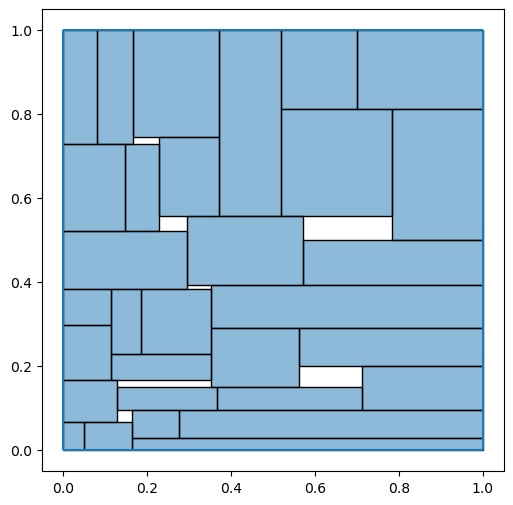

In [ ]:

rects_sol = sol.x.reshape(-1,4)
fig, ax = plt.subplots(figsize=(6, 6))
# ax = draw_rectangles(ax, np.c_[rects_sol,np.array([0,0,0,0])])
# ax = draw_rectangles(ax, clinched_rectangles)
ax = draw_rectangles(ax, rects_sol)

plt.show()

In [ ]:
(rects_sol[:,2]*rects_sol[:,3]).sum()

0.9721516226985573

#### minimizing with SLSQP

In [5]:
from SquareDivision.optimization.constraints import constraints_SLSQP
from SquareDivision.optimization.objective_function import (
    dist_fun
)
constraints_for_SLSQP = constraints_SLSQP(clinched_rectangles,east_neighbours, north_neighbours, holes)

In [6]:
from scipy.optimize import minimize
sol = minimize(dist_fun, x0=clinched_rectangles.flatten(), args=(clinched_rectangles), jac=True, method='slsqp', constraints=constraints_for_SLSQP)#, bounds=bounds)

ValueError: negative dimensions are not allowed

In [7]:
for constrain in constraints_for_SLSQP:
    print(constrain['fun'](clinched_rectangles.flatten()).shape)

(124,)
(124,)
(124,)
(124,)
(27,)
(36,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)


7